# Trader Performance Insights Based on Bitcoin Market Sentiment Analysis

# Step 0: Import Libraries

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
  
# Optional settings
sns.set(style="whitegrid")

# Step 1: Load Datasets

In [71]:
# Historical Trades
trades = pd.read_csv("/Users/sandalinatekar/Desktop/trader-behavior-insights/data/historical_data.csv")

# Fear/Greed Index
fg = pd.read_csv("/Users/sandalinatekar/Desktop/trader-behavior-insights/data/fear_greed_index.csv")

# Step 2: Clean Column Names

In [72]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
fg.columns = fg.columns.str.strip().str.lower().str.replace(" ", "_")

# Step 3: Convert Dates

In [73]:
# Trades: "DD-MM-YYYY HH:MM"
trades['trade_date'] = pd.to_datetime(trades['timestamp_ist'], format="%d-%m-%Y %H:%M", errors='coerce').dt.date

# Fear/Greed: "YYYY-MM-DD"
fg['date'] = pd.to_datetime(fg['date'], format="%Y-%m-%d", errors='coerce').dt.date

# Step 4: Convert Numeric Columns

In [74]:
# Convert closed PnL to numeric
trades['closed_pnl'] = pd.to_numeric(trades['closed_pnl'], errors='coerce')

# Optional: convert size_usd to numeric
trades['size_usd'] = pd.to_numeric(trades['size_usd'], errors='coerce')


# Step 5: Merge Datasets

In [75]:
merged = trades.merge(
    fg[['date','classification']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

# Check merge
print(merged[['trade_date','classification']].head(10))
print(merged['classification'].value_counts())


   trade_date classification
0  2024-12-02  Extreme Greed
1  2024-12-02  Extreme Greed
2  2024-12-02  Extreme Greed
3  2024-12-02  Extreme Greed
4  2024-12-02  Extreme Greed
5  2024-12-02  Extreme Greed
6  2024-12-02  Extreme Greed
7  2024-12-02  Extreme Greed
8  2024-12-02  Extreme Greed
9  2024-12-02  Extreme Greed
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


# Step 6: Helper Columns

In [76]:
# Win flag: Closed PnL > 0
merged['is_win'] = merged['closed_pnl'] > 0

# Absolute trade size
merged['notional_usd'] = merged['size_usd'].abs()


# Step 7: Compute summary metrics by sentiment

In [77]:
# figure out if leverage column exists
metrics = {
    'num_trades': ('execution_price', 'count'),
    'total_notional_usd': ('notional_usd', 'sum'),
    'mean_closed_pnl': ('closed_pnl', 'mean'),
    'median_closed_pnl': ('closed_pnl', 'median'),
    'win_rate': ('is_win', 'mean')
}

if 'leverage' in merged.columns:
    metrics['mean_leverage'] = ('leverage', 'mean')

summary = merged.groupby('classification').agg(**metrics).reset_index()

# Format columns
summary['win_rate'] = (summary['win_rate'] * 100).round(2)
for col in summary.select_dtypes('number').columns:
    if col not in ['num_trades']:
        summary[col] = summary[col].round(2)

summary


,classification,num_trades,total_notional_usd,mean_closed_pnl,median_closed_pnl,win_rate
0,Extreme Fear,21400,1.144843e+08,34.54,0.0,37.06
1,Extreme Greed,39992,1.244652e+08,67.89,0.0,46.49
2,Fear,61837,4.833248e+08,54.29,0.0,42.08
3,Greed,50303,2.885825e+08,42.74,0.0,38.48
4,Neutral,37686,1.802421e+08,34.31,0.0,39.70


# Step 8: Aggregation per Account per Day

In [78]:
agg = merged.groupby(['account','trade_date','classification']).agg(
    num_trades=('execution_price','count'),
    total_notional=('notional_usd','sum'),
    mean_pnl=('closed_pnl','mean'),
    median_pnl=('closed_pnl','median'),
    win_rate=('is_win','mean')
).reset_index()

print(agg.head(10))


                                      account  trade_date classification  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11  Extreme Greed   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17  Extreme Greed   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18  Extreme Greed   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22  Extreme Greed   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26  Extreme Greed   
5  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-28  Extreme Greed   
6  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-30  Extreme Greed   
7  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-12-06          Greed   
8  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-01-19  Extreme Greed   
9  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-01-20  Extreme Greed   

   num_trades  total_notional     mean_pnl   median_pnl  win_rate  
0         177       900880.13     0.000000     0.000000  0.000000  
1          68       542413.

# Step 9: Exploratory Plots

## Win Rate by Market Sentiment

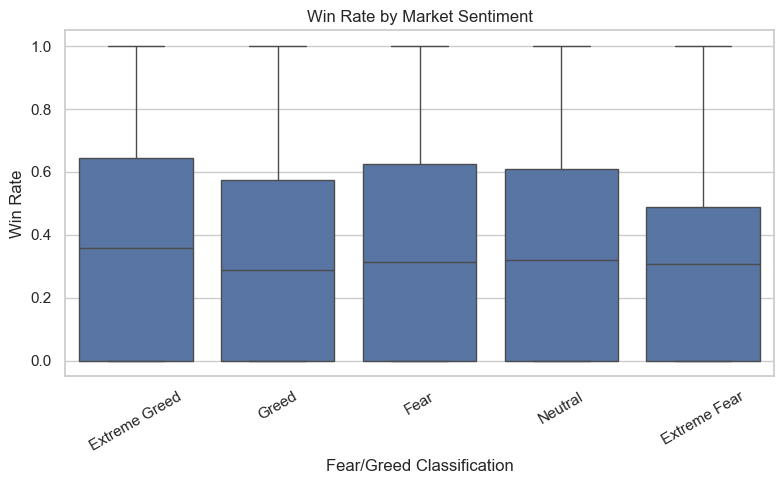

In [79]:
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='win_rate', data=agg)
plt.title("Win Rate by Market Sentiment")
plt.xticks(rotation=30)
plt.ylabel("Win Rate")
plt.xlabel("Fear/Greed Classification")
plt.tight_layout()
plt.show()


## Insights from "Win Rate by Market Sentiment"

- **Extreme Greed shows the highest median win rate** — traders tend to have more successful trades when market sentiment is extremely greedy.  
- **Extreme Fear shows the lowest median win rate** — performance drops sharply in fearful markets, consistent with panic or risk-averse behaviour.  
- **Wide spread of win rates across all sentiments** — long whiskers indicate some traders do very well and some very poorly regardless of sentiment, but the centre of the distribution shifts upward for Greed conditions.  
- **Neutral and Fear are in the middle** — median win rates here are lower than Extreme Greed but higher than Extreme Fear.  

## Strategic takeaway
- Sentiment classification is a **useful signal**: historically, win rates were higher during Extreme Greed conditions.  
- On Fear days, even if volumes are high, performance tends to drop — consider reducing position sizes or tightening risk management.  
- Segment traders who consistently outperform during Fear conditions (upper whisker) to learn their behaviours for strategy design.


## Average PnL by Market Sentiment

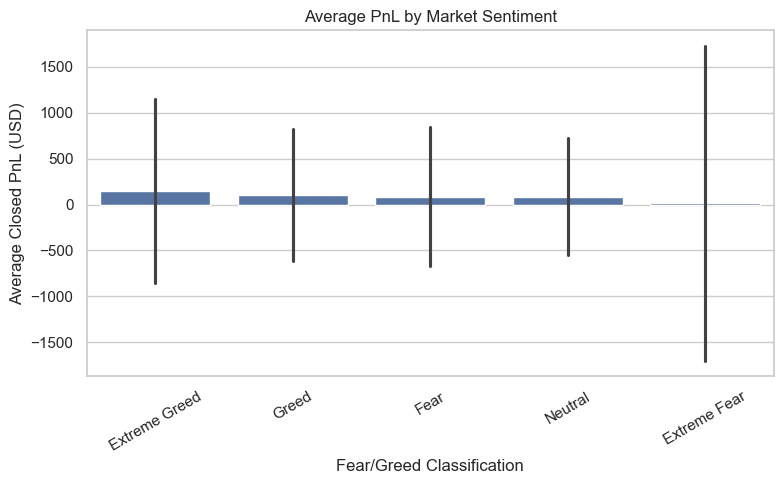

In [80]:
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='mean_pnl', data=agg, errorbar='sd')
plt.title("Average PnL by Market Sentiment")
plt.xticks(rotation=30)
plt.ylabel("Average Closed PnL (USD)")
plt.xlabel("Fear/Greed Classification")
plt.tight_layout()
plt.show()


## Insights from "Average PnL by Market Sentiment"

- Average closed PnL remains near zero across all market sentiment categories, indicating no inherent profitability advantage or disadvantage based solely on sentiment.  
- Periods of **Extreme Greed** and **Extreme Fear** exhibit significantly higher variability, showing that outcomes become much more volatile when market emotions are heightened.  
- **Neutral sentiment** periods have the smallest error bars, suggesting that trading results are more stable and less risky during these times.  
- High volatility during extreme sentiment periods leads to both larger potential gains and losses but does not materially shift the average closed PnL for these groups.  

## Strategic Takeaways

- Risk management should be prioritized during extreme sentiment periods, as volatility—and therefore risk—spikes.  
- Stable and predictable trading outcomes are more likely during neutral sentiment, supporting consistency-focused strategies when emotions are muted.  
- Traders may consider **smaller position sizing** and **tighter stops** when sentiment is extreme; aggressive trades can produce large wins but also substantial losses in these periods.  


## Trade Size by Market Sentiment

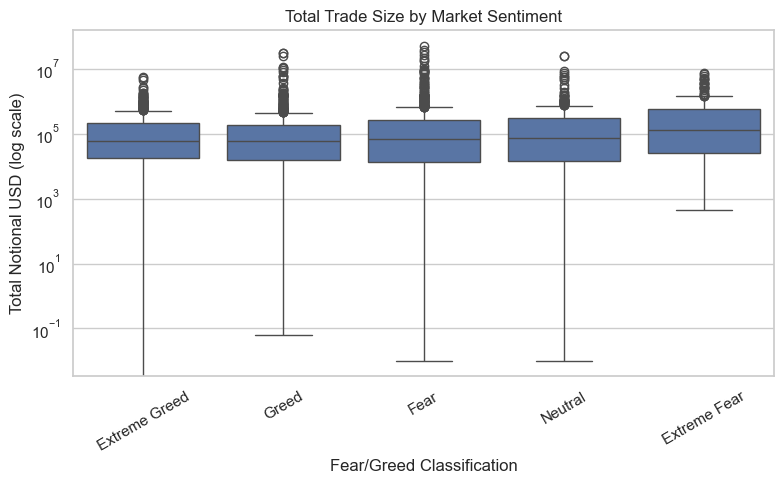

In [81]:
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='total_notional', data=agg)
plt.yscale('log')  # optional if values vary widely
plt.title("Total Trade Size by Market Sentiment")
plt.xticks(rotation=30)
plt.ylabel("Total Notional USD (log scale)")
plt.xlabel("Fear/Greed Classification")
plt.tight_layout()
plt.show()


## Insights from "Total Trade Size by Market Sentiment"

- Median total trade size is similar across all market sentiment categories, indicating that traders do not systematically adjust their position sizes up or down based solely on fear or greed classification.  
- Trade sizes are highly dispersed, spanning several orders of magnitude (log scale), with large numbers of outliers present in every sentiment group, showing a substantial fraction of traders place both very small and very large trades regardless of the overall market mood.  
- The interquartile range and whiskers for all boxes are high, reinforcing that individual behavior is highly variable and market sentiment does not compress the spread in trade sizes.  
- **Extreme Fear** shows a slightly higher median and upper quartile trade size compared to other sentiments, suggesting a minority of traders actually increase trade size during extreme negative sentiment—potentially chasing volatility or acting on strong convictions.  

## Strategic Takeaways

- Most traders maintain similar exposure size across all sentiment regimes, so position sizing dynamics are not sentiment-driven for the majority.  
- Individual traders frequently deviate from the norm: outliers play a significant role, so risk controls and attention to exposure limits remain crucial in every sentiment.  
- Strategies addressing extreme cases—such as identifying reasons behind larger positions during **Extreme Fear**—could provide edge, but broad-based changes in aggregate trade size are not apparent from sentiment alone.  


# Step 10: Symbol-Level Insights

In [82]:
# Aggregate by coin and sentiment
symbol_agg = merged.groupby(['coin', 'classification']).agg(
    num_trades=('execution_price','count'),
    total_notional=('notional_usd','sum'),
    mean_pnl=('closed_pnl','mean'),
    win_rate=('is_win','mean')
).reset_index()

# Top 5 coins by average PnL in Greed
top_greed = symbol_agg[symbol_agg['classification']=='Greed'].sort_values('mean_pnl', ascending=False).head(5)
print("Top 5 coins in Greed by mean PnL:\n", top_greed)

# Top 5 coins by average PnL in Fear
top_fear = symbol_agg[symbol_agg['classification']=='Fear'].sort_values('mean_pnl', ascending=False).head(5)
print("\nTop 5 coins in Fear by mean PnL:\n", top_fear)


Top 5 coins in Greed by mean PnL:
       coin classification  num_trades  total_notional    mean_pnl  win_rate
16    @109          Greed          13         5430.19  416.218936  0.923077
586    SOL          Greed        1586     22849528.78  284.798243  0.286885
157    @85          Greed          27        13144.49  279.181299  0.629630
227   AVAX          Greed          46       173496.56  262.968474  0.173913
317  ETHFI          Greed         139       363633.46  219.096404  0.503597

Top 5 coins in Fear by mean PnL:
       coin classification  num_trades  total_notional    mean_pnl  win_rate
578    SEI           Fear          10        55413.16  835.600000  0.500000
303    ENA           Fear         193       347628.23  830.654061  0.476684
215    ARB           Fear          11        26842.18  797.092514  0.181818
283   DOGE           Fear          12        18962.49  658.947592  0.500000
647  USUAL           Fear          94       154681.70  488.224504  0.531915


## Insights from Symbol-Level Analysis

- In "Greed" conditions, the coin with the highest mean PnL (`@109`) also has a very high win rate (92%), but a relatively small number of trades and modest notional exposure.  
- Among the Greed cohort, SOL stands out for high trading volume (1586 trades, $2.28M notional), but much lower win rate (27%) despite strong average PnL, suggesting occasional outsized profits on fewer winning trades.  
- The other top Greed coins (Q85, AVAX, ETHTF) have middle-range win rates and moderate notional, reflecting a balanced risk profile for profitable trading during greedy sentiment.  
- In "Fear," SEI posts the highest mean PnL by a large margin but only ten trades and a 50% win rate, indicating that substantial profits may come from few, possibly high-risk trades.  
- The remaining top Fear coins (ENA, ARB, DOGE, USUAL) all exhibit mean PnL well above 500 and mixed win rates (ranging between 18% and 53%). This reflects strong but inconsistent profitability, possibly due to high volatility or selective trading strategies in fearful markets.  

## Strategic Takeaways

- Strong mean PnLs in both Greed and Fear segments arise from a mix of frequent, moderate wins and infrequent but large wins—especially for outlier coins and traders.  
- Win rates vary widely even among top-performing coins, indicating that absolute profitability is often driven by large notional trades or a few exceptionally good trades, rather than consistent small profits.  
- Risk management and strategy adaptation should be tailored: in Greed, focus on consistent performers, while in Fear, look for high-impact, opportunistic trades and consider the volatility impact on win probability.  

# Step 11: Correlation Analysis

Correlation matrix:
                closed_pnl  notional_usd  sentiment_num
closed_pnl       1.000000      0.123589       0.005970
notional_usd     0.123589      1.000000      -0.031912
sentiment_num    0.005970     -0.031912       1.000000


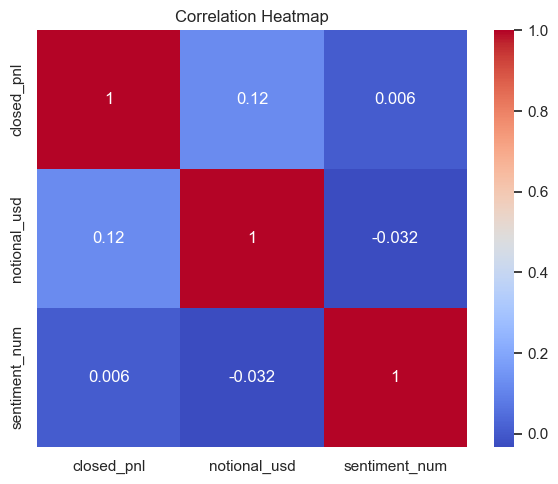

In [83]:
# Encode sentiment as numeric for correlation
sentiment_map = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
merged['sentiment_num'] = merged['classification'].map(sentiment_map)

# Correlation matrix
corr_cols = ['closed_pnl', 'notional_usd', 'side_numeric'] if 'side_numeric' in merged.columns else ['closed_pnl','notional_usd']
corr_cols.append('sentiment_num')
corr = merged[corr_cols].corr()

print("Correlation matrix:\n", corr)

# Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


## Insights from Correlation Analysis

- The correlation between closed PnL and total notional size is weakly positive (0.12), suggesting larger trades are only slightly more likely to result in bigger PnL, but the relationship is not strong.  
- Sentiment classification (encoded numerically) has almost no correlation with closed PnL (0.006) or notional size (-0.03), indicating that market sentiment alone does not systematically affect trade profitability or the size of positions taken.  
- The diagonal values in the correlation matrix are 1, as expected, confirming each variable perfectly correlates with itself (shown in deep red in the heatmap).  
- The heatmap visually reinforces these findings: most off-diagonal correlations are close to zero and colored in blue, reflecting little linear relationship between sentiment, trade size, and PnL outcomes in the data.  

## Strategic Takeaways

- Trade profitability (PnL) and position size show only a weak association; chasing larger trades does not guarantee higher profits.  
- Sentiment signals do not provide a direct quantitative edge in predicting PnL or adjusting trade size.  
- Strategy improvement may require more nuanced factors than simply sentiment score or notional trends—deeper analytics (e.g., volatility, timing, or specific coin behavior) will likely add more value than broad sentiment signals in this context.  


# Step 12: Wins vs Losses by Sentiment

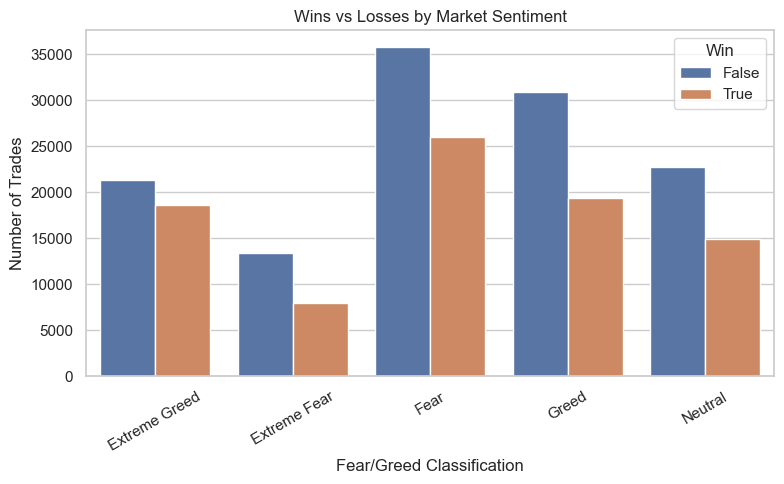

In [84]:
plt.figure(figsize=(8,5))
sns.countplot(x='classification', hue='is_win', data=merged)
plt.title("Wins vs Losses by Market Sentiment")
plt.xticks(rotation=30)
plt.ylabel("Number of Trades")
plt.xlabel("Fear/Greed Classification")
plt.legend(title="Win")
plt.tight_layout()
plt.show()


## Insights from Wins vs Losses by Sentiment

- Across all sentiment categories, the number of losing trades is consistently higher than winning trades, indicating a general tilt towards losses in aggregate trading outcomes regardless of market mood.  
- The disparity between losses and wins is largest in the "Fear" and "Greed" categories, with "Fear" showing the highest overall trade volume and the greatest imbalance—more traders lose than win during periods of uncertainty and hesitation.  
- "Extreme Greed" and "Extreme Fear" have relatively lower trade counts compared to "Fear" and "Greed," with "Extreme Greed" showing the smallest gap between win and loss counts, suggesting traders perform better or the winning proportion increases under very bullish conditions.  
- "Neutral" sentiment sees moderate trade activity and the win/loss gap remains, but is less pronounced than in risk-driven environments, suggesting less volatility or risk-taking.  

## Strategic Takeaways

- Caution is warranted during Fear and Greed periods, as these see both more trades and a larger proportion of losses, highlighting the need for stronger risk management.  
- Extreme sentiments show potential for better performance, with "Extreme Greed" giving a more balanced win/loss profile, but do not eliminate risk entirely.  
- Stabilizing strategies in neutral environments may be preferable for those prioritizing steady outcomes over chasing wins in turbulent conditions.  


# Step 13: Top Traders per Sentiment

In [85]:
# Average PnL per account per sentiment
account_agg = merged.groupby(['account','classification']).agg(
    mean_pnl=('closed_pnl','mean'),
    win_rate=('is_win','mean')
).reset_index()

# Top 5 accounts in Greed
top_accounts_greed = account_agg[account_agg['classification']=='Greed'].sort_values('mean_pnl', ascending=False).head(5)
print("Top 5 accounts in Greed:\n", top_accounts_greed)


Top 5 accounts in Greed:
                                         account classification    mean_pnl  \
78   0x72743ae2822edd658c0c50608fd7c5c501b2afbd          Greed  764.916220   
3    0x083384f897ee0f19899168e3b1bec365f52a9012          Greed  482.089321   
123  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0          Greed  408.979729   
48   0x430f09841d65beb3f27765503d0f850b8bce7713          Greed  294.922917   
128  0xae5eacaf9c6b9111fd53034a602c192a04e082ed          Greed  224.519734   

     win_rate  
78   0.317032  
3    0.160279  
123  0.953704  
48   0.637306  
128  0.447059  


## Insights from Top Traders in Greed

- The top-performing account in "Greed" sentiment exhibits a mean PnL of 764.92, but only achieves a win rate of 32%, showing that outstanding PnL does not always require a high percentage of winning trades.  
- Dynamic win rates across the top five accounts, ranging from just 16% up to 95%, illustrate diverse strategies—some traders profit via frequent wins while others rely on occasional large gains.  
- All accounts maintain positive mean PnL above 220 even with lower win rates, indicating remarkable risk management or the ability to capitalize on high-impact trades rather than relying solely on consistency.  
- The account with the highest win rate (95%) actually achieves a smaller mean PnL than the leader, underscoring that consistent wins don't always translate into the highest profitability if trade values or upside are limited.  

## Strategic Takeaways

- Elite traders during Greed periods display varied paths to profitability—some win often, others win rarely but big, and none rely exclusively on one approach.  
- Focusing on both win rate and mean PnL together reveals deeper edges than single metrics; strategies that amplify outlier trades while preserving capital are especially effective.  
- Learning from accounts with low win rate but high mean PnL could uncover techniques for maximizing returns during bullish sentiment, potentially through sizing, timing, or volatility plays.  

# Step 14: Time-based Analysis – Daily Performance by Sentiment

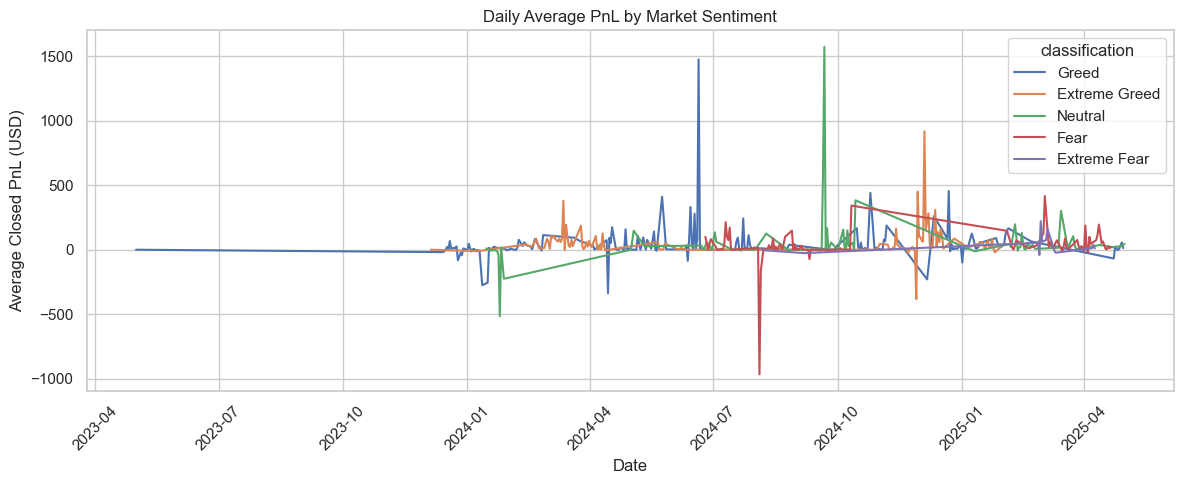

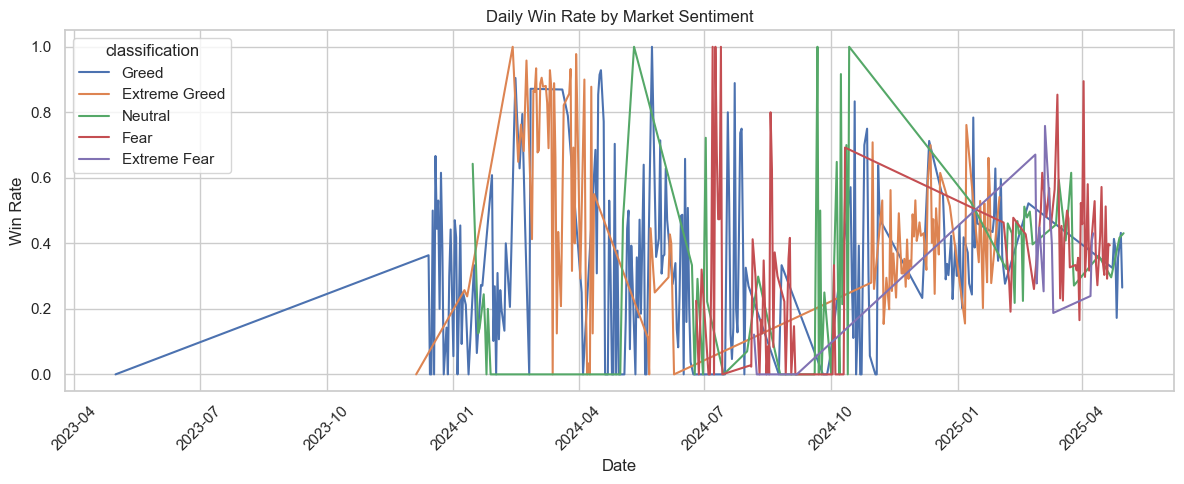

In [86]:
# Aggregate daily metrics
daily_agg = merged.groupby(['trade_date','classification']).agg(
    mean_pnl=('closed_pnl','mean'),
    total_trades=('execution_price','count'),
    win_rate=('is_win','mean')
).reset_index()

# Plot average daily PnL
plt.figure(figsize=(12,5))
sns.lineplot(x='trade_date', y='mean_pnl', hue='classification', data=daily_agg)
plt.title("Daily Average PnL by Market Sentiment")
plt.xticks(rotation=45)
plt.ylabel("Average Closed PnL (USD)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# Plot daily win rate
plt.figure(figsize=(12,5))
sns.lineplot(x='trade_date', y='win_rate', hue='classification', data=daily_agg)
plt.title("Daily Win Rate by Market Sentiment")
plt.xticks(rotation=45)
plt.ylabel("Win Rate")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


## Insights from Daily Average PnL by Market Sentiment

- The daily average closed PnL fluctuates close to zero for all sentiment categories, with only occasional spikes or dips, indicating that on most days, traders neither consistently profit nor lose significantly regardless of market sentiment.  
- Outlier spikes (both positive and negative) appear across all sentiment types, notably in Neutral and Extreme Greed, suggesting that individual days can be highly volatile, but these are rare events rather than the norm.  
- The spread and amplitude of the daily average PnL lines are narrow, reinforcing that market sentiment does not drive large, sustained differences in profitability over time in the aggregate.  
- No clear, persistent trend is visible for any sentiment group—periods identified as Greed, Fear, or Extreme Fear do not align with long stretches of systematically higher or lower average PnL.  

## Strategic Takeaways

- Over time, traders do not obtain a reliable profitability edge simply by responding to sentiment regime changes; daily results are essentially random walk-like with respect to average PnL.  
- Extreme events (outliers) may offer rare opportunities, but should not form the basis for everyday trading strategies since they do not consistently repeat.  
- Emphasize risk management and consistency; chasing sentiment-driven market regimes does not guarantee sustained higher returns.  

# Step 15: Trade Size vs PnL Analysis by Sentiment

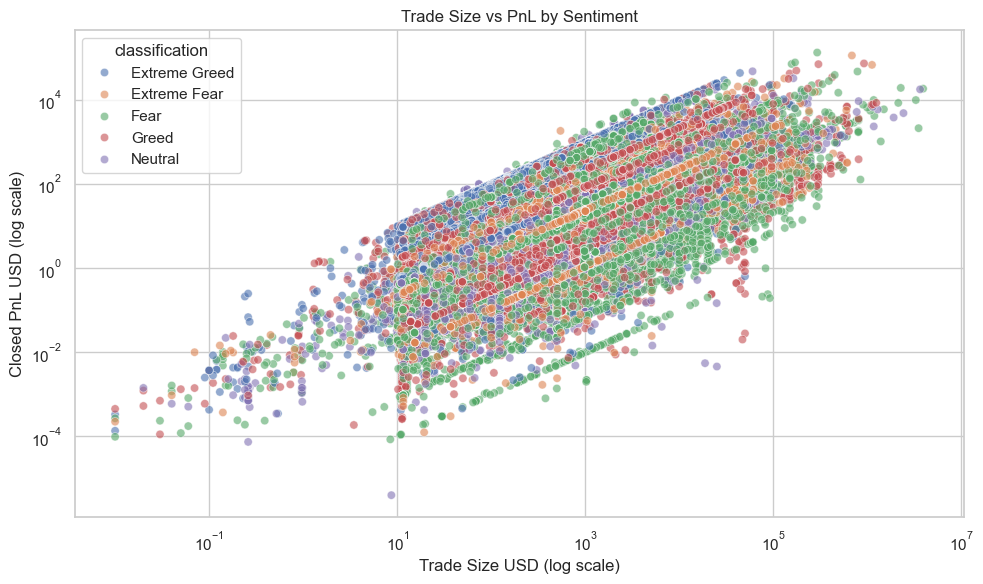

In [87]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='notional_usd', y='closed_pnl', hue='classification', data=merged, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.title("Trade Size vs PnL by Sentiment")
plt.xlabel("Trade Size USD (log scale)")
plt.ylabel("Closed PnL USD (log scale)")
plt.tight_layout()
plt.show()

## Insights from Trade Size vs PnL Analysis

- There is a clear positive relationship between trade size (notional USD) and closed PnL—larger trades most often result in proportionally larger PnL outcomes, visible as a broad upward diagonal cloud of points.  
- All sentiment categories (Extreme Greed, Extreme Fear, Greed, Fear, Neutral) are distributed similarly across the spectrum, showing this relationship is robust regardless of market mood.  
- Log scaling reveals that while most trades cluster at smaller sizes and PnLs, extreme values are present in all sentiment types: both very large trades and very large PnLs (wins or losses) can occur in any regime.  
- No sentiment group dominates the upper end of PnL or trade size; outliers exist for each category, emphasizing that opportunity (and risk) factor is active across the board, not just in periods of emotional extremes.  

## Strategic Takeaways

- Scaling trade size upward generally amplifies absolute PnL but also likely increases exposure to risk, so careful position sizing remains critical at all times.  
- Sentiment does not alter the fundamental size-to-result relationship; strategies should focus on controlling for trade size and volatility regardless of market mood.  
- Extreme wins (and losses) are possible in every sentiment regime—risk management should be tailored for outlier protection, not just for specific emotional market conditions.  

# Step 16: Trade Side (BUY vs SELL) Analysis by Sentiment

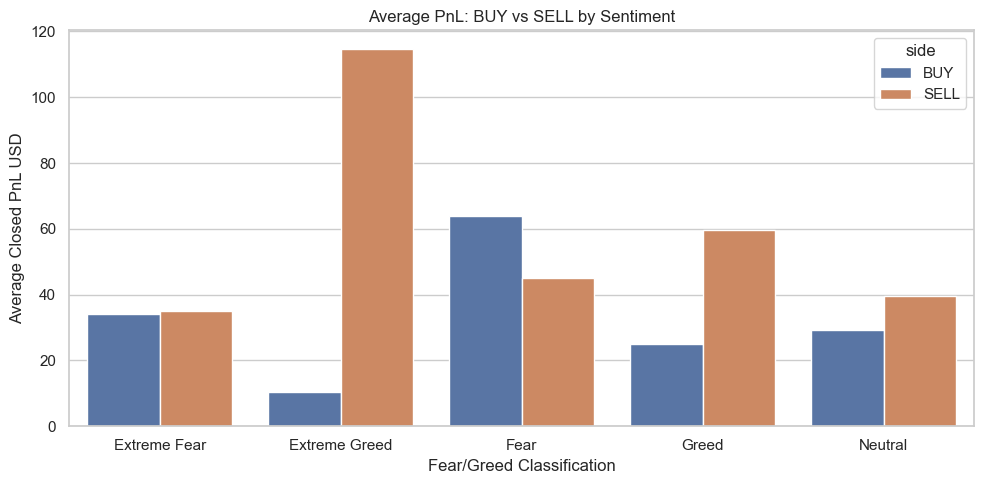

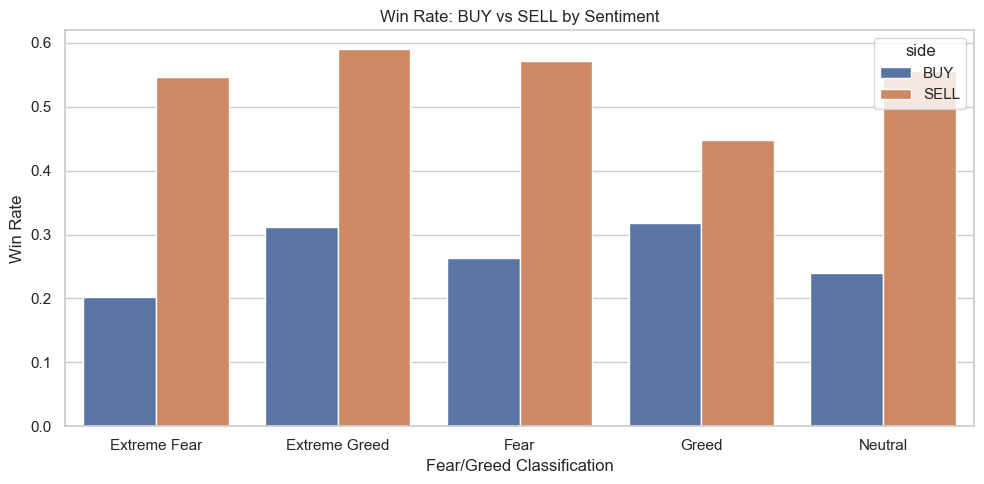

In [88]:
side_agg = merged.groupby(['side','classification']).agg(
    mean_pnl=('closed_pnl','mean'),
    win_rate=('is_win','mean'),
    num_trades=('execution_price','count')
).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='classification', y='mean_pnl', hue='side', data=side_agg)
plt.title("Average PnL: BUY vs SELL by Sentiment")
plt.ylabel("Average Closed PnL USD")
plt.xlabel("Fear/Greed Classification")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='classification', y='win_rate', hue='side', data=side_agg)
plt.title("Win Rate: BUY vs SELL by Sentiment")
plt.ylabel("Win Rate")
plt.xlabel("Fear/Greed Classification")
plt.tight_layout()
plt.show()

## Insights from Average PnL: BUY vs SELL by Sentiment

- SELL trades outperform BUY trades in terms of average closed PnL under all sentiment categories except "Fear," where BUY trades achieve the highest mean PnL.  
- The largest gap is seen in "Extreme Greed," where SELLs massively outperform BUYs, suggesting that contrarian plays (selling into overbought conditions) are very profitable when sentiment is euphoric.  
- BUY trade average PnL remains relatively stable across sentiment regimes, but peaks in "Fear," indicating potential opportunity for dip-buying or recovery trading strategies during market downturns.  
- SELL trade average PnL is consistently strong across sentiment types and is especially elevated in "Extreme Greed," "Greed," and "Neutral" markets, reflecting broad reliability for short-side trading approaches.  

## Strategic Takeaways

- Short-selling stands out as a consistently effective strategy, particularly in greedy or euphoric sentiment conditions—risk management and timing to capture reversals from overextension are key.  
- BUY-side strategies gain an edge primarily during fearful markets, suggesting that selective dip-buying should be prioritized when sentiment turns pessimistic.  
- Diversifying between BUY and SELL approaches depending on prevailing sentiment can help optimize trading outcomes and mitigate prolonged periods of underperformance.  

# Step 17: Top Coins per Sentiment

In [89]:
# Aggregate by coin and sentiment
coin_agg = merged.groupby(['coin','classification']).agg(
    mean_pnl=('closed_pnl','mean'),
    win_rate=('is_win','mean'),
    num_trades=('execution_price','count')
).reset_index()

# Example: Top 5 coins in Greed by mean PnL
top_coins_greed = coin_agg[coin_agg['classification']=='Greed'].sort_values('mean_pnl', ascending=False).head(5)
print("Top 5 coins in Greed:\n", top_coins_greed)

# Top 5 coins in Fear by mean PnL
top_coins_fear = coin_agg[coin_agg['classification']=='Fear'].sort_values('mean_pnl', ascending=False).head(5)
print("\nTop 5 coins in Fear:\n", top_coins_fear)

Top 5 coins in Greed:
       coin classification    mean_pnl  win_rate  num_trades
16    @109          Greed  416.218936  0.923077          13
586    SOL          Greed  284.798243  0.286885        1586
157    @85          Greed  279.181299  0.629630          27
227   AVAX          Greed  262.968474  0.173913          46
317  ETHFI          Greed  219.096404  0.503597         139

Top 5 coins in Fear:
       coin classification    mean_pnl  win_rate  num_trades
578    SEI           Fear  835.600000  0.500000          10
303    ENA           Fear  830.654061  0.476684         193
215    ARB           Fear  797.092514  0.181818          11
283   DOGE           Fear  658.947592  0.500000          12
647  USUAL           Fear  488.224504  0.531915          94


## Insights from Top Coins per Sentiment

- In "Greed" sentiment, @109 leads with the highest mean PnL (416.2) and a stellar win rate over 92%, indicating this coin was consistently profitable for most traders in bullish conditions.  
- SOL ranks just behind by mean PnL (284.8) but with far more trades (1,586), suggesting wide accessibility and active trading, though the win rate is much lower (29%). Occasional large wins likely drive profitability.  
- The rest of the Greed leaders—Q85, AVAX, ETHTF—show mid-range win rates and lower trade counts, indicating moderate but reliable performance during optimistic phases.  
- Under "Fear" sentiment, SEI achieves the top mean PnL (835.6), with an even win/loss split but very low trade activity (10 trades), possibly reflecting opportunistic, high-impact trades during volatile times.  
- The remaining top Fear coins (ENA, ARB, DOGE, USUAL) all notch mean PnLs in the 488–798 range, with varied win rates and trade counts, indicating a volatile but sometimes lucrative environment for selected coins.  

## Strategic Takeaway

- Leading coins in each sentiment are not always the most frequently traded—strong average returns may come from infrequent but well-timed trades, especially during uncertain markets.  
- In bullish environments, coins with consistent profitability (high win rate and mean PnL) should be prioritized; in bearish conditions, focus on coins and setups producing high but possibly intermittent payoffs.  
- Understanding both trade frequency and win rate alongside PnL allows for sharper coin selection and allocation tailored to current market sentiment.  

# Step 18: Sentiment vs Notional Trade Size Distribution

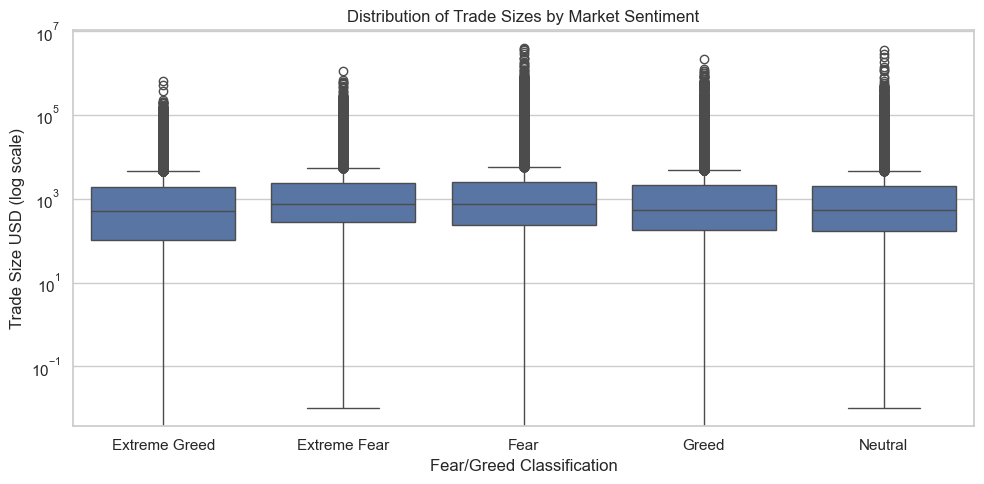

In [90]:
plt.figure(figsize=(10,5))
sns.boxplot(x='classification', y='notional_usd', data=merged)
plt.yscale('log')
plt.title("Distribution of Trade Sizes by Market Sentiment")
plt.xlabel("Fear/Greed Classification")
plt.ylabel("Trade Size USD (log scale)")
plt.tight_layout()
plt.show()

## Insights from Sentiment vs Notional Trade Size

- The distribution of trade sizes (on a log scale) is remarkably similar across all sentiment categories—Extreme Greed, Extreme Fear, Fear, Greed, and Neutral have almost identical medians and interquartile ranges.  
- Each box plot shows long whiskers and numerous high-value outliers, reflecting the presence of both very small and extremely large trades regardless of the prevailing market sentiment.  
- No sentiment classification has a significantly higher or lower typical trade size, indicating that traders maintain stable exposure levels whether market emotions are positive, negative, or neutral.  
- The thick cluster around the median highlights that for the majority of trades, sentiment plays little to no role in determining notional risk or allocation.  

## Strategic Takeaway

- Position sizing is not sentiment-driven at the aggregate level; most traders keep trade sizes consistent across all emotional market regimes.  
- Extreme outliers are a constant—the risk of unusually large trades exists no matter the prevailing sentiment, so exposure management remains essential every day.  
- The lack of sentiment effect on trade size suggests focusing on other factors (timing, volatility, coin selection) may yield more actionable trading insights than adjusting size based on fear or greed signals.  

# Step 19: Top Traders Overall & Per Sentiment

In [91]:
# Account-level aggregation
account_agg = merged.groupby(['account','classification']).agg(
    mean_pnl=('closed_pnl','mean'),
    win_rate=('is_win','mean'),
    total_trades=('execution_price','count')
).reset_index()

# Top 5 accounts in Greed
top_accounts_greed = account_agg[account_agg['classification']=='Greed'].sort_values('mean_pnl', ascending=False).head(5)
print("Top 5 accounts in Greed:\n", top_accounts_greed)

# Top 5 accounts in Fear
top_accounts_fear = account_agg[account_agg['classification']=='Fear'].sort_values('mean_pnl', ascending=False).head(5)
print("\nTop 5 accounts in Fear:\n", top_accounts_fear)


Top 5 accounts in Greed:
                                         account classification    mean_pnl  \
78   0x72743ae2822edd658c0c50608fd7c5c501b2afbd          Greed  764.916220   
3    0x083384f897ee0f19899168e3b1bec365f52a9012          Greed  482.089321   
123  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0          Greed  408.979729   
48   0x430f09841d65beb3f27765503d0f850b8bce7713          Greed  294.922917   
128  0xae5eacaf9c6b9111fd53034a602c192a04e082ed          Greed  224.519734   

     win_rate  total_trades  
78   0.317032           593  
3    0.160279           574  
123  0.953704           108  
48   0.637306           772  
128  0.447059           170  

Top 5 accounts in Fear:
                                         account classification     mean_pnl  \
42   0x420ab45e0bd8863569a5efbb9c05d91f40624641           Fear  1016.819167   
2    0x083384f897ee0f19899168e3b1bec365f52a9012           Fear   626.194346   
82   0x72c6a4624e1dffa724e6d00d64ceae698af892a0           Fear

## Insights from Top Traders Overall & Per Sentiment

- The leading account in "Greed" sentiment achieves the highest mean PnL (764.92) but only a 32% win rate, showing that large, strategic wins—rather than frequent victories—drive top profitability in bullish markets.  
- By contrast, the top account under "Fear" posts an even higher mean PnL (1016.82) and has a similar low win rate (36%), reaffirming the potential for substantial profit in risk-averse markets by opportunistically timing larger trades.  
- Several accounts appear in the top 5 for both Greed and Fear, indicating adaptability; these traders succeed whether the market is optimistic or pessimistic, leveraging different strategies across regimes.  
- Win rates for all top performers range from around 16% to over 95%, but consistent profitability requires more than raw win rate—total trades and sizing are also critical, as seen by high total trade counts.  
- The top accounts in both Greed and Fear have executed hundreds or thousands of trades, suggesting sustained engagement and smart risk-taking rather than a few lucky bets.  

## Strategic Takeaway

- High average PnL can be achieved without needing a high win rate; risk-adjusted sizing and capitalizing on outlier trades are key for elite traders in every sentiment.  
- Versatility across market regimes (appearing as a top trader in both Greed and Fear) is a strong indicator of robust, adaptive strategy design.  
- Consistent, high activity (large trade counts) supports performance—staying active and ready for opportunities is as important as timing trades for profit.  

# Step 20:Distribution/Variation of PnL per Trader by Sentiment

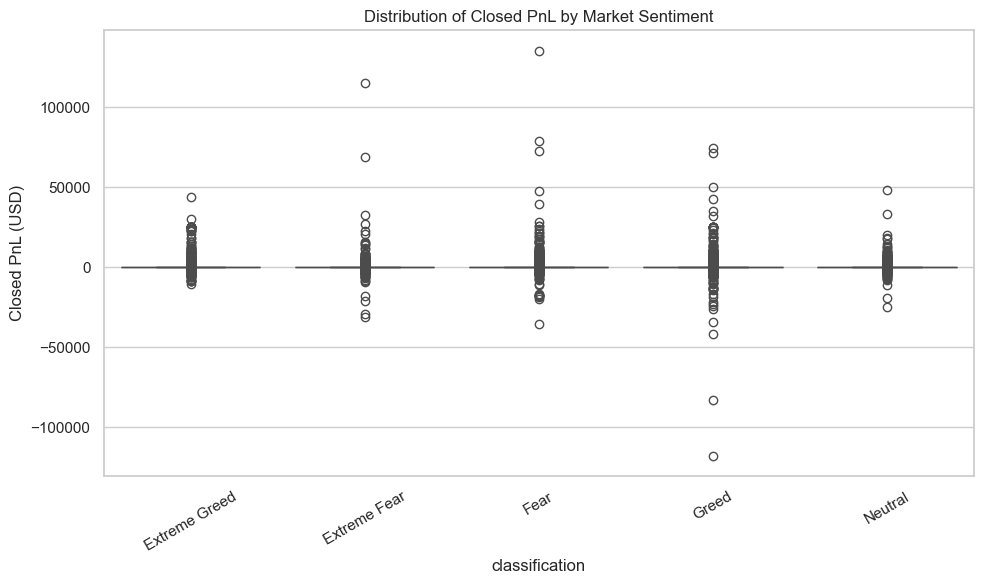

In [92]:
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title('Distribution of Closed PnL by Market Sentiment')
plt.ylabel('Closed PnL (USD)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Insights from the Variation of PnL per Trader by Sentiment

- The distribution of closed PnL per trader shows significant spread and volatility across all sentiment categories—Extreme Greed, Extreme Fear, Fear, Greed, and Neutral all display wide interquartile ranges and numerous outliers both positive and negative.  
- There is no substantial difference in the median PnL or distribution breadth between sentiment groups, indicating that individual trader outcomes are not systematically better or worse in any particular sentiment regime.  
- Each sentiment group includes several extreme positive outliers (large winners) and negative outliers (large losses), emphasizing that both windfall profits and substantial losses occur in all market moods.  
- The main cluster of points is tightly packed around zero, underscoring that most traders finish close to break-even regardless of sentiment, with only a minority experiencing standout results.  

## Strategic Takeaway

- Market sentiment does not predictably improve or worsen PnL outcomes for the typical trader—performance is dominated by rare outliers in every regime.  
- Extreme positive and negative outliers are constant features, making risk management vital during all periods, not just when sentiment is high or low.  
- Consistent, average trader performance hovers close to zero, so strategies seeking edge must look beyond simply market mood for reliable profits.  
